In [94]:
import pandas as pd
import numpy as np

# Select Transactions from DB

In [95]:
import psycopg2 
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os


load_dotenv()


hostname=os.getenv("hostname")
database=os.getenv("database")
username=os.getenv("username")
pwd=os.getenv("pwd")
port_id=os.getenv("port_id")
host = os.getenv("host")


In [96]:
conn_string = f"postgresql://{username}:{pwd}@{host}:{port_id}/{database}"
db =  create_engine(url=conn_string)
conn=db.connect()

df = pd.read_sql("SELECT * FROM transactions", db)

df.head()



,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,id
0,10/28/2022,Joint,MSFT,Microsoft Corporation - Common Stock Option Ty...,Stock Option,Sale (Full),"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,0
1,10/31/2022,Joint,CLF,Cleveland-Cliffs Inc. Common Stock,Stock,Purchase,"$15,001 - $50,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,1
2,10/28/2022,Joint,MSFT,Microsoft Corporation - Common Stock Option Ty...,Stock Option,Sale (Full),"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,2
3,10/28/2022,Joint,MSFT,Microsoft Corporation - Common Stock Option Ty...,Stock Option,Sale (Full),"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,3
4,10/24/2022,Joint,MSFT,Microsoft Corporation - Common Stock,Stock,Purchase,"$15,001 - $50,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,4


# Gather Tickers and Transaction Dates

In [97]:
dateSer = df.groupby("ticker")['transaction_date'].min()
dateSer.head()

ticker
--         01/01/2014
0QZI.IL    09/25/2019
3V64.TI    09/25/2019
A          02/24/2015
AA         01/06/2021
Name: transaction_date, dtype: object

In [98]:
allTickers = list(dateSer.index)
allTickers[:5]

['--', '0QZI.IL', '3V64.TI', 'A', 'AA']

In [99]:
load_dotenv()

apiKey = os.getenv('apiKey')

# tick = 'KO'
# tick = 'IBM'
tick = 'TSLA'

testEndpoint =f"https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY&symbol={tick}&apikey={apiKey}"

print(testEndpoint)


https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY&symbol=TSLA&apikey=U288LAEMR485UKD1


In [100]:

import requests

response = requests.get(testEndpoint)
responseText = response.text
print(response.text[:460])

{
    "Meta Data": {
        "1. Information": "Weekly Prices (open, high, low, close) and Volumes",
        "2. Symbol": "TSLA",
        "3. Last Refreshed": "2022-11-11",
        "4. Time Zone": "US/Eastern"
    },
    "Weekly Time Series": {
        "2022-11-11": {
            "1. open": "208.6500",
            "2. high": "208.9000",
            "3. low": "177.1200",
            "4. close": "195.9700",
            "5. volume": "596889173"
        },
   


In [101]:
import json 

jsonData = json.loads(responseText)
allWeeksData = jsonData['Weekly Time Series']
allWeeks = list(allWeeksData.keys())

firstWeek = allWeeks[0]
firstWeekData =allWeeksData[firstWeek ]
historicalPrices = pd.json_normalize(firstWeekData)
historicalPrices['date'] = firstWeek

historicalPrices = historicalPrices.head(0)

for wk in allWeeks: 
    currentWeekData = allWeeksData[wk]
    currentFrame = pd.json_normalize(currentWeekData)
    currentFrame['date'] = wk
    historicalPrices = pd.concat([historicalPrices, currentFrame])

historicalPrices.head()

,1. open,2. high,3. low,4. close,5. volume,date
0,208.6500,208.9000,177.1200,195.9700,596889173,2022-11-11
0,226.1900,237.3951,203.0800,207.4700,342474516,2022-11-04
0,205.8200,233.8100,198.5863,228.5200,413072923,2022-10-28
0,210.0400,229.8200,202.0000,214.4400,415404010,2022-10-21
0,223.9300,226.9900,204.1600,204.9900,397406475,2022-10-14


In [102]:
historicalPrices.tail()

,1. open,2. high,3. low,4. close,5. volume,date
0,20.5000,22.1800,19.5200,19.5900,4399700,2010-08-06
0,21.5000,21.5000,19.5500,19.9400,3052000,2010-07-30
0,21.3700,22.2500,19.5000,21.2900,7175700,2010-07-23
0,17.9500,21.5000,16.9000,20.6400,15438900,2010-07-16
0,20.0000,20.0000,14.9800,17.4000,25550600,2010-07-09


In [105]:
historicalPrices.shape

(645, 6)

In [103]:
historicalPrices['4. close'] = historicalPrices['4. close'].astype(float)
historicalPrices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 645 entries, 0 to 0
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   1. open    645 non-null    object 
 1   2. high    645 non-null    object 
 2   3. low     645 non-null    object 
 3   4. close   645 non-null    float64
 4   5. volume  645 non-null    object 
 5   date       645 non-null    object 
dtypes: float64(1), object(5)
memory usage: 35.3+ KB


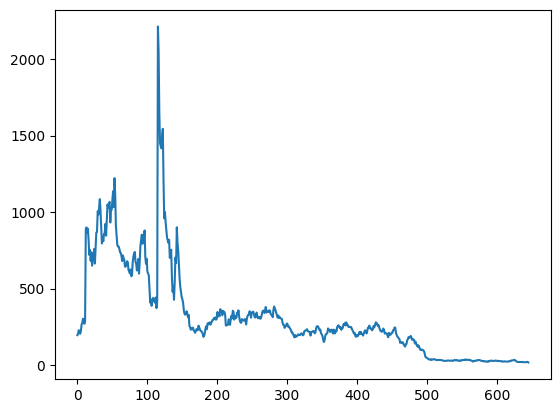

In [104]:
import matplotlib.pyplot as plt



# plt.plot(historicalPrices['4. close'], linestyle = 'dotted')
plt.plot(np.array(historicalPrices['4. close']), linestyle = 'solid')
plt.show()